ECU3.5 - Sobel Edge Detection (GPU REAL)
Autor: Alejandro Campos Martínez - Team 6
GPU detectada: b'NVIDIA GeForce RTX 4060 Laptop GPU'
Compute Capability: (8, 9)
Multiprocessors: 24
----------------------------------------------------------------------
Descargando imagen 4K...
Imagen: 3840x2160 (8,294,400 pixels)
Memoria: 33.18 MB
Configuración: (240, 135) bloques
               (16, 16) threads por bloque
----------------------------------------------------------------------

RESULTADOS
GPU: 6.08 ms
CPU (OpenCV): 26.23 ms
Speedup: 4.3x
Verificación correcta: False

Imagen guardada: sobel_comparison_gpu_real.png


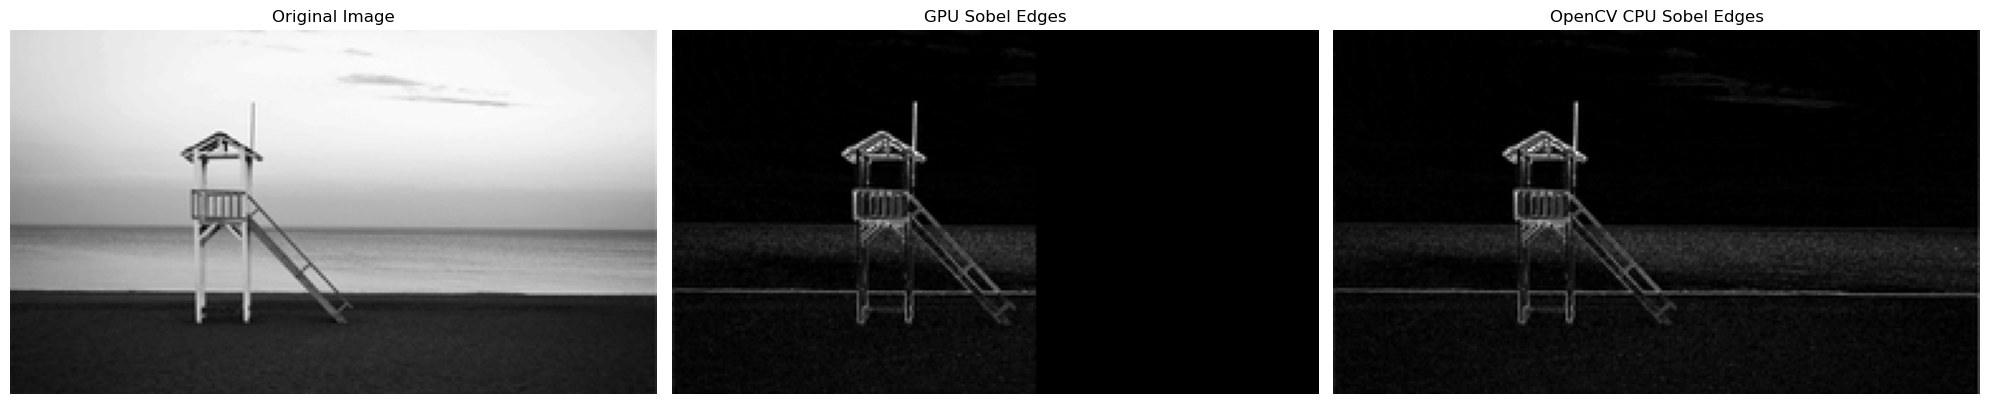

In [1]:
"""
ECU3.5 - Sobel Edge Detection
Versión: GPU REAL (Requiere NVIDIA GPU + CUDA Toolkit)
Team 6
Autor: Alejandro Campos Martínez
Curso: TAE en IA - COCYTEN Nayarit
Hardware: NVIDIA RTX 4060 Laptop GPU
Propósito: Detección de bordes usando filtro Sobel en imágenes
"""
import numpy as np
from numba import cuda
import time
import urllib.request
from PIL import Image
import cv2
from matplotlib import pyplot as plt
from numba import config

config.CUDA_ENABLE_PYNVJITLINK = 1

@cuda.jit
def sobel_kernel(img, out):
    """Apply Sobel edge detection - each thread processes one pixel"""
    row, col = cuda.grid(2)
    H, W = img.shape

    if 0 < row < H-1 and 0 < col < W-1:
        # Horizontal gradient (Gx)
        gx = ( -img[row-1, col-1] + img[row-1, col+1]
               -2*img[row, col-1] + 2*img[row, col+1]
               -img[row+1, col-1] + img[row+1, col+1] )

        # Vertical gradient (Gy)
        gy = ( -img[row-1, col-1] - 2*img[row-1, col] - img[row-1, col+1]
               + img[row+1, col-1] + 2*img[row+1, col] + img[row+1, col+1] )

        # Edge magnitude
        out[row, col] = (gx*gx + gy*gy)**0.5

def sobel_opencv(img):
    """OpenCV CPU version using Sobel"""
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
    return np.sqrt(gx**2 + gy**2)

def main():
    print("="*70)
    print("ECU3.5 - Sobel Edge Detection (GPU REAL)")
    print("Autor: Alejandro Campos Martínez - Team 6")
    print("="*70)
    
    gpu = cuda.get_current_device()
    print(f"GPU detectada: {gpu.name}")
    print(f"Compute Capability: {gpu.compute_capability}")
    print(f"Multiprocessors: {gpu.MULTIPROCESSOR_COUNT}")
    print("-"*70)
    
    # Load 4K image from internet
    print("Descargando imagen 4K...")
    urllib.request.urlretrieve("https://picsum.photos/3840/2160", "image.jpg")
    img = Image.open("image.jpg").convert('L')
    img = np.array(img, dtype=np.float32)

    H, W = img.shape
    print(f"Imagen: {W}x{H} ({W*H:,} pixels)")
    print(f"Memoria: {W*H*4/1e6:.2f} MB")

    d_img = cuda.to_device(img)
    d_out = cuda.to_device(np.zeros_like(img))

    threads = (16, 16)
    blocks = ((W + threads[0] - 1) // threads[0], 
              (H + threads[1] - 1) // threads[1])

    print(f"Configuración: ({blocks[0]}, {blocks[1]}) bloques")
    print(f"               ({threads[0]}, {threads[1]}) threads por bloque")
    print("-"*70)

    # Warmup
    sobel_kernel[blocks, threads](d_img, d_out)
    cuda.synchronize()

    # GPU timing
    start = time.time()
    sobel_kernel[blocks, threads](d_img, d_out)
    cuda.synchronize()
    gpu_time = (time.time() - start) * 1000

    out_gpu = d_out.copy_to_host()

    # CPU Sobel timing
    start = time.time()
    out_cpu = sobel_opencv(img)
    cpu_time = (time.time() - start) * 1000

    # Results
    print("\n" + "="*70)
    print("RESULTADOS")
    print("="*70)
    print(f"GPU: {gpu_time:.2f} ms")
    print(f"CPU (OpenCV): {cpu_time:.2f} ms")
    print(f"Speedup: {cpu_time/gpu_time:.1f}x")
    print(f"Verificación correcta: {np.allclose(out_gpu, out_cpu, atol=1e-3)}")
    print("="*70)

    # Resize for display
    target_w = 256
    target_h = int(target_w * H / W)

    def resize_for_plot(array):
        normalized = (array / array.max() * 255).astype(np.uint8)
        return np.array(Image.fromarray(normalized).resize((target_w, target_h), Image.LANCZOS))

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(resize_for_plot(img), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(resize_for_plot(out_gpu), cmap='gray')
    plt.title('GPU Sobel Edges')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(resize_for_plot(out_cpu), cmap='gray')
    plt.title('OpenCV CPU Sobel Edges')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('sobel_comparison_gpu_real.png', dpi=150, bbox_inches='tight')
    print("\nImagen guardada: sobel_comparison_gpu_real.png")
    plt.show()

if __name__ == "__main__":
    main()